In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
def process_input(file):
    data = None
    print(file)
    with open(file, 'r') as fd:
        data = fd.read().split()

    # print(f'len of data: {len(data)}')
    return data


def convert_to_ms(data):
    # unit is ms
    data = [round(float(i) * 1000, 2) for i in data]
    return data

# TODO: This is for the mini dataset only. 
# needs to account for full data. which frames are the original frame for each scene
def compute_delays(data):
    # print(f'Start: {data[0]}, end: {data[-1]}, total:{data[-1] - data[0]}')
    # compute delays
    delay_list = []
    for i, num in enumerate(data):
        if i == 0:
            continue
        else:
            delay = data[i] - data[i - 1]
            delay_list.append(delay)
    return delay_list

def xxx(input_file):
    processed_data = process_input(input_file)
    processed_data = convert_to_ms(processed_data)
    delays = compute_delays(processed_data)
    return delays

In [3]:
def load_data_concat(per_files):
    combined_delays = []
    for file in per_files:
        file_path = Path(file)
        # print(file_path.parent, file_path.name)
        delays = xxx(file)
        combined_delays.append(delays)
    delays_arr = np.asarray(combined_delays)
    delays_mean = delays_arr.flatten()
    # print('Return data shape', delays_mean.shape)
    return delays_mean

### LOAD NUSCENES DATA

In [4]:
target = ''
with open('adperf_results.txt', 'r') as fd:
    target = fd.read()

subjects = [[f'{target}/delays.txt']]
print(subjects)
data = []
for index, file in enumerate(subjects):
    delays = load_data_concat(file)
    data.append(delays)

[['../data/model_output/250319-145309/delays.txt']]
../data/model_output/250319-145309/delays.txt


### Raw delay analysis on nuscenes mini

In [5]:
def compute_extra_delay_compensated(original_list, expected_processing_time=50):
    ret_list = []

    for val in original_list:
        val_to_add = max(0, val - expected_processing_time)
        ret_list.append(val_to_add)

    return ret_list


def compute_apollo_drop(original_list, threshold=50):
    assert len(original_list) % 5 == 0
    unique_scenes_len = len(original_list) // 5
    alarm_list = []
    incurred_delays = 0
    for i, val in enumerate(original_list):
        # check restart
        if (i + 1) % unique_scenes_len == 0:
            incurred_delays = 0
        # check drop point
        if incurred_delays >= threshold:
            incurred_delays = max(incurred_delays - threshold, 0)
            # save alarm
            alarm_list.append(i)
        else:
            incurred_delays += val

    return alarm_list   

### Compute drops

drop frames: []
Drop rate reset:0.0


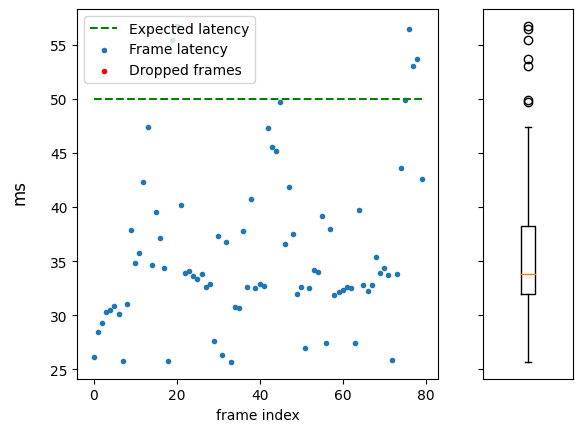

In [6]:
for index, rnd_data in enumerate(data):
    fig, ax = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [4, 1]}, sharey=True)
    # threshold
    ax[0].plot([50] * len(data[0]), '--', color='green', label='Expected latency')
    # process delays
    extra_delay_compensated = compute_extra_delay_compensated(rnd_data)

    dropped_frames_reset = compute_apollo_drop(extra_delay_compensated)
    print('drop frames:', dropped_frames_reset)
    with open('../../trajectron_input/frames_dropped.txt', 'w') as fd:
        fd.write(','.join([str(x) for x in dropped_frames_reset]))
    dropped_values_reset = [rnd_data[x] for x in dropped_frames_reset]

    print(f'Drop rate reset:{len(dropped_frames_reset) / len(extra_delay_compensated)}')

    ax[0].scatter(range(len(rnd_data)), rnd_data, marker='.', label='Frame latency')
    # ax[0].plot(rnd_data)
    ax[0].scatter(dropped_frames_reset, dropped_values_reset, marker='.', color='red', label='Dropped frames')

    fig.supylabel('ms')
    ax[0].set_xlabel('frame index')
    ax[0].legend(loc='upper left')

    # boxplot distribution
    ax[1].boxplot(rnd_data)
    ax[1].set_xticks([])

    plt.show()